# Import all libraries

**After uploading the .ipython file to the Github, we found that there are some problems with the page display. Maybe it happened because of the system. So hopefully that makes sense to you. Thank you so much in advance :)**

In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from wordcloud import WordCloud, STOPWORDS
from urllib import request
from bs4 import BeautifulSoup
from nltk.tokenize import RegexpTokenizer
import nltk
from nltk import word_tokenize
import os
import math
import requests
import collections

# Part 1: Build our network

* Nodes: 610 nodes (users). 
* Edges: 164054 edges. If two users have seen one same movie, add an edge between these two nodes.

**Step 1:** Extract userId, movieId from different files.    
**Step 2:** If two users have rated one same movie, add an edge between them.   
**Step 3:** Draw the network.   
**Step 4:** Plot the degree distribution.

In [2]:
# Get all files and briefly see the top 5 rows
ratings = pd.read_csv('ml-latest-small/ratings.csv')
movies = pd.read_csv('ml-latest-small/movies.csv')
links = pd.read_csv('ml-latest-small/links.csv')

**Below we show the detailed content of the three files.**

In [3]:
ratings.head(5)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [4]:
movies.head(5)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
links.head(5)

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


**There are 9742 movies from movies file.**

In [6]:
print('The number of all movies:',len(movies['movieId']))

The number of all movies: 9742


**For each movie, we find all ids of users that have rated it. Then add them all into another list to store('user_id' below). Every element of 'user_id' is a list of user's ids about one movie that these users rated, from movie 1 to movie 9742.**

In [7]:
# for every movie, get all user id when they watch the same movie
user_id = []
# extract all movie id
movies_id = movies['movieId'].tolist()

for i in movies_id:
    user_edge = ratings.loc[ratings['movieId']==i]['userId'].tolist()
    user_id.append(user_edge)

**For every list in user_id, we want everyone to be linked to each other. For each user, We let it connect to other people starting at its next point until to the last person, which avoids the self-loops. And then we build the network. We plan to create a graph with 610 users as nodes, and if two of them have rated the same movie, we add an edge between them.**

In [8]:
# Build the network
G = nx.Graph()

for user_edge in user_id:
    for i in user_edge:
        for j in user_edge[user_edge.index(i)+1:]:
            G.add_edge(i,j)
        
print(G)       

Graph with 610 nodes and 164054 edges


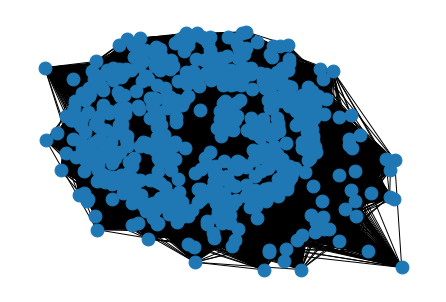

In [9]:
nx.draw(G, node_size=i*0.5)

**From the graph that we've got, we know that everyone has seen the same movie as different other users because the number of nodes is 610 and there are a lot of nodes connecting many edges, which also means that the values of nodes'degree are high.**

Text(609, 17, '[max degree=609, count=17]')

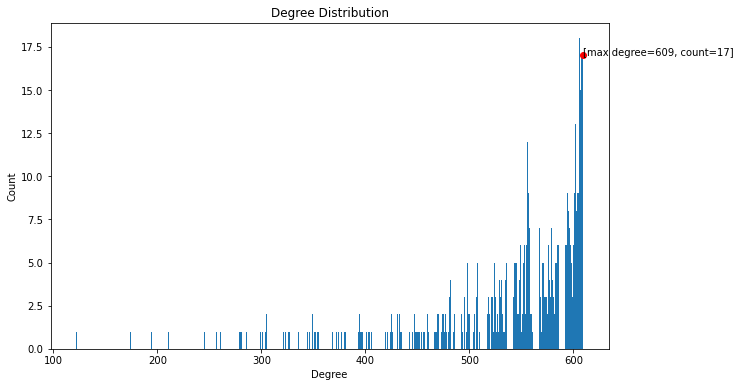

In [10]:
# Plot degree distribution of network
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

plt.figure(figsize=(10,6))
plt.bar(deg, cnt)
plt.xlabel('Degree')
plt.ylabel('Count')
plt.title('Degree Distribution')

# Get the index of max degree and plot it with its count
max_indx = deg.index(max(deg))
plt.plot(deg[max_indx],cnt[max_indx], 'o', color='red')
show_max = '[max degree=' + str(deg[max_indx]) + ', count=' + str(cnt[max_indx]) + ']'
plt.annotate(show_max,xytext=(deg[max_indx],cnt[max_indx]),xy=(deg[max_indx],cnt[max_indx]))

**According to the bar plot of degree distribution, we get the same result as that we mentioned. Most of nodes'degrees are between 500 and 600. The highest degree is more than 600 and the count is almost 18.**

In [11]:
print('The maximun of degree is:',max(deg))
print('The number of nodes with the greatest degree is:',cnt[list(deg).index(max(deg))])

The maximun of degree is: 609
The number of nodes with the greatest degree is: 17


# Part 2: Draw wordcloud of top 5 users

We intend to find the top 5 users that have the largest degrees.  
The larger degree of node means that this user saw more same movies with others. In other words, this user has similar tastes as many people about watching movies. We analyze those people, so we not only can get their movie keywords but also get a relatively accurate selection of viewing categories about public.   
From degree distribution and results above, we know that there are 17 users connecting to everyone else because the value of degree is 609 which is the maximum. So we just choose top 5 users from them.   
Finally, we draw the wordclouds of their movies genres in order to see the tastes of them more consicely.   

**Step 1:** Find the top 5 nodes (users) with largest degrees.    
**Step 2:** Extract genres of movies that those users have seen and add them into 5 strings respectively.   
**Step 3:** Draw 5 wordclouds of those strings.   

In [12]:
# find top five users
max_user = []
for i,j in nx.degree(G):
    if j == 609:
        max_user.append(i)
        if len(max_user) == 5:
            break

print('top five users:',max_user)

top five users: [140, 177, 182, 274, 288]


**We create two functions to extract genre of all movies that every user have seen firstly, and then draw the word-cloud of that to get viewing key words of five users.**

In [14]:
# function to extract genre of all movies that users have seen
def text_genre(movie_id):
    text_list = ''
    for i in movie_id:
        genre = movies.loc[movies['movieId']==i]['genres'].tolist()
        genre = genre[0].replace("|", " ")
        text_list += genre
    return text_list

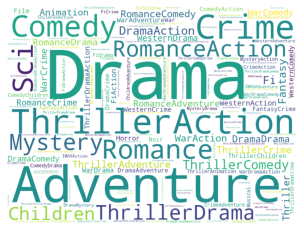

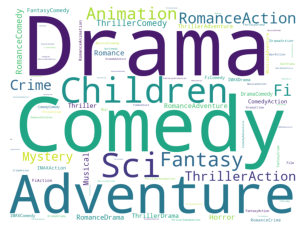

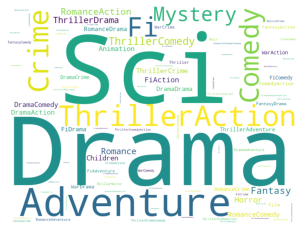

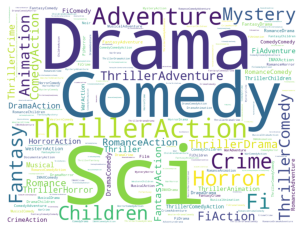

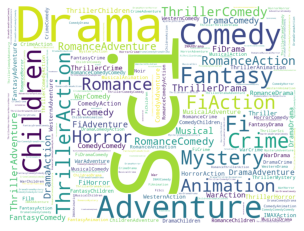

In [15]:
# function to draw word-cloud
def draw_word_cloud(word_str):
    wordcloud = WordCloud(
        stopwords=STOPWORDS,
        background_color='white',
        max_words= 200,
        width=800,
        height=600,
        collocations=False
    ).generate(word_str)
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

# get the preference word cloud of top five users
for user in max_user:
    movie_id = ratings.loc[ratings['userId']==user]['movieId']
    text = text_genre(movie_id)
    draw_word_cloud(text)

**In terms of five word-clouds, we know that these five users have a little bit different viewing selection, but the most choice is 'Drama', which represents that most people all like to see.**

# Part3: Review analysis

For each one of top 5 users, we separately extract all the public text reviews for all movies rated by that person. Then use *sentiment value* of reviews from public to see if their reviews match the person's ratings, and to what extent, so we could define if this person is a professional movie critic and also can find which person most likely to be a professional film critic in these 5 users.

**Step 1:** Extract adjectives from reviews of public from the movie reviews page.    
**Step 2:** Calculate sentiment value of each movie reviewed by public.   
**Step 3:** Compare sentiment value of public's review with the rating value of user. 

**Firstly, for five users, we create a function to get the imdb ids of movies that every user has seen. There are three different ids and links of every movie, but we choose the imdb id because we can get public reviews only in the website.**

In [16]:
# function to get the imdb id of movies that user has seen
def movie_imdbId(user):
    movie_id = ratings.loc[ratings['userId']==user]['movieId']
    movie_imdbId = []
    for i in movie_id:
        imdb_id = links.loc[links['movieId']==i]['imdbId']
        movie_imdbId.append(str(int(imdb_id)).zfill(7))
        
    return movie_imdbId

**And then, we create a function to extract adjectives of public reviews from movie pages for the calculation of sentiment value in the next step.**

In [17]:
# function to extract adj from the review website of movie
def text_review(movie):
    link = requests.get('https://www.imdb.com/title/tt'+ movie +'/reviews?ref_=tt_urv')
    if link.status_code == 200:
        html = request.urlopen('https://www.imdb.com/title/tt'+ movie +'/reviews?ref_=tt_urv').read()
        raw = BeautifulSoup(html, 'html.parser').get_text()
        words = word_tokenize(raw)
        tags = nltk.pos_tag(words)
        tokens = [s1 for (s1,s2) in tags if s2 in ['JJ', 'JJR', 'JJS']]
        JJ = [w.lower() for w in tokens]
        text_JJ = " ".join(JJ)
    else:
        text_JJ = 'nothing'
        
    return text_JJ

**Write adjectives of every movies into text files and storage on our computer for each user in order to run code faster later.**

In [18]:
# # create txt files about movies that user has seen
# for user in max_user:
#     pages_path = r'./'+str(int(user))+'/'
#     for movie in movie_imdbId(user):
#         text = text_review(movie)
#         f = open(pages_path + movie + '.txt','w', encoding='utf-8')
#         f.write(text)

**For the part of calculation sentiment value about public reviews, first of all, we get sentiment words and their corresponding happiness average values based on the LabMT word list(Data Set S1) from Exercise 8.**

In [19]:
# get sentiment words and happiness average value from the file
sentiment = pd.read_csv('dataset1.csv')

word = sentiment['word']
havg = sentiment['happiness_average']

word_list = []
havg_list = []

for i in word:
    word_list.append(i)
    
for i in havg:
    havg_list.append(i)

**We use this equation to caluculate sentiment values:**
$$ S = \frac{\sum_{i=0}^{N_p} w{p_i} + {\sum_{j=0}^{N_n} w{p_j}}} {{N_p}+{N_n}} $$
subject to ${N_p},{N_n}$ is word count of positive and negative sentiment respectively, $w{p_i}, w{p_j}$ is weight of positive and negative sentiment each.   
In the sentiment list of LabMT wordlist, we loop every word whatever it is positiver or negative. If the word appears in the text content of character, the total count adds 1 and we also get a cumulative sentiment weight value. Finally, the sentiment value means to divide the cumulative value by total count.

In [20]:
# function to calculate public rattings
def sentiment_value(character):
    sum = 0
    num = 0
    sen_value = 0
    for i in character:
        for j in word_list:
            if i==j:
                sum += havg_list[word_list.index(j)]
                num += 1
    if num == 0:
        sen_value = 0
    else:
        sen_value = sum/num
    
    return sen_value

**After getting sentiment value of public's review for the first time, we found that the range of value is different from user's ratting range, which is from 0 to 5, so we use Min-Max Scaler to compress the value between 0 and 1. And then multiply the value by 5 and keep it in one decimal place to get the final sentiment value of public reviews. This operation is convinent for next comparision between public rating and user's rating.**

**In this function, we continue to calculate accuracy of movie ratings from every user. First, we set the difference between public and user ratings at 0 to 0.8. As long as the difference is within this range, we think the user scores successful. Then get the percentage of such cases in the total. The larger percentage, the better rating.**

In [21]:
# function to calculate the accuracy of ratio about that top five users give the ratings to movies
def user_pub_ratio(user):
    pages_path = r'./'+str(int(user))+'/'
    
    pub_ratting_list = []
    for i in movie_imdbId(user):
        if not os.path.getsize(pages_path + i + '.txt'):
            pub_ratting_list.append(0)
        else:
            txt = open(pages_path + i + '.txt', encoding='utf-8').read().split(' ')
            pub_ratting_list.append(sentiment_value(txt))

    # Min_Max Scaler: [0, 1]
    pub_ratting_list = (pub_ratting_list - np.min(pub_ratting_list)) / (np.max(pub_ratting_list) - np.min(pub_ratting_list))
    # [0, 5]
    pub_ratting_list *= 5
    pub_ratting_list = np.round(pub_ratting_list,1).tolist()
    
    
    # get the movie ratings of user 
    user_ratings = ratings.loc[ratings['userId']==user]['rating'].tolist()
    
    # get the rating accuracy of user
    sum = 0
    for i in pub_ratting_list:
        j = user_ratings[pub_ratting_list.index(i)]
        if math.fabs(i - j) <= 0.8:
            sum += 1
    ratio = sum/len(user_ratings)
    
    return ratio

In [22]:
for user in max_user:
    ratio = user_pub_ratio(user)
    print(f'user{user}_pub_ratio is:{ratio}')

user140_pub_ratio is:0.5592105263157895
user177_pub_ratio is:0.5442477876106194
user182_pub_ratio is:0.654042988741044
user274_pub_ratio is:0.6062407132243685
user288_pub_ratio is:0.5421800947867299


**Finally, we get the rating ratios from five users, the user whose id is 182 got the largest percentage, so this one is the most professional movie critic.**